# Ch 1. Regression Models

## 1.1 Linear Regression

Mathematical notation of standard linear regression.

$$
y_n = \alpha + \beta x_n + \epsilon_n \quad \text{where} \quad \epsilon_n \sim N(0, \sigma) \\
y_n \sim N(\alpha + \beta X_n, \sigma)
$$

This is shown in Stan below.

```c
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    y ~ normal(alpha + beta * x, sigma);
}
```

Note that the model is vectorized such that each data point is not iterated over as shown below.
The vectorized version is not only easier to read, but runs faster, too.

```c
model {
    for (n in 1:N)
        y[n] ~ normal(alpha + beta * x[n], sigma)
}
```

This vectorization along with overloading the arithmetic operators allows for easy use of matrix in the models, too.

```c
data {
    int<lower=0> N;  // number of data points
    int<lower=0> K;  // number of predictors (columns)
    matrix[N, K] x;  // predictor matrix
    vector[N] y;     // outcome vector
}

parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;
}

model {
    y ~ normal(x * beta + alpha, sigma)
}
```

### Example

An example of a simple linear regression.
The Stan model is available in [stan-models/ch01_regression-models_m1.stan](stan-models/ch01_regression-models_m1.stan)

In [1]:
import pystan
from matplotlib import pyplot as plt
import arviz as az
import numpy as np

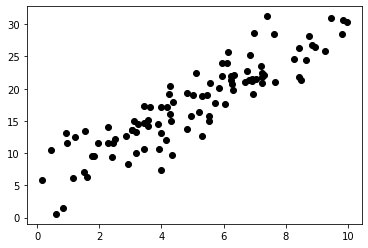

In [3]:
np.random.seed(123)

N = 100
alpha_real = 5.0
beta_real = 2.5
sigma_real = 3.0

x = np.random.uniform(0, 10, N)
y = alpha_real + beta_real * x + np.random.normal(0, sigma_real, N)

plt.plot(x, y, 'ko')
plt.show()

In [5]:
lm_m1_data = {
    'N': N,
    'x': x,
    'y': y
}

lm_m1 = pystan.StanModel(file='stan-models/ch01_regression-models_m1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_811f32dcbac7f45107073d98cec5a743 NOW.


In [7]:
lm_m1_fit = lm_m1.sampling(data=lm_m1_data, iter=1000, chains=4)

/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d413dd0>,
      dtype=object)

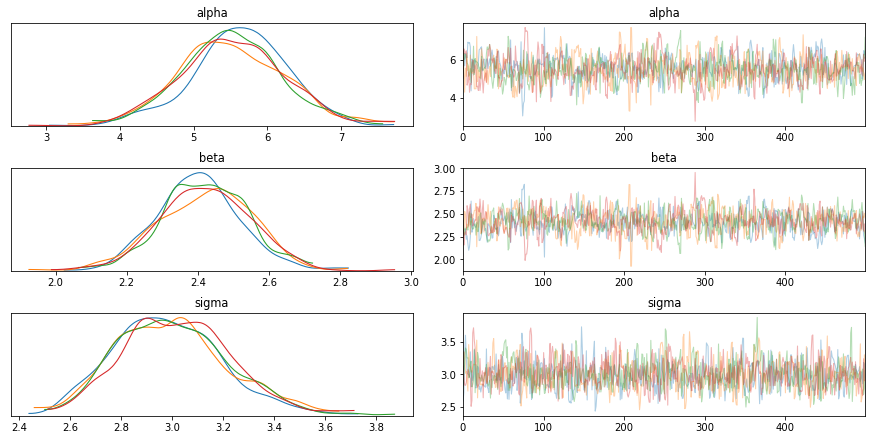

In [8]:
az_lm_m1_fit = az.from_pystan(lm_m1_fit, posterior_model=lm_m1_fit)
az.plot_trace(az_lm_m1_fit)